## Decision Support for Decarbonizing Port Operations
#### TIØ4550 - Financial Engineering, Specialization Project

In this jupyter notebook, the MILP model for optimal investments to decarbonize a port's cargo handling handling equipment is implemented. This work is done as part of the work for project thesis at the Norwegian University of Science and Technology in the fall of 2024. The jupyter notebook imports input parameters that are defined in a separate Excel-file with a certain structure. Note that a license is needed for the package *gurobipy* to be able to run the code. Some of the plots below are specifically plotted for the case study in the project thesis and would not be applicable to a general case. The Excel-files for all the scenarios and this code can be found at: https://github.com/arnastri/Project-Thesis-in-TIO-4550-Financial-Engineering-Specialization-Project

Authors: Andrea Harstad Nakken, Arnas Tribusininas, Marte Ribe (2024)

-----------------------------------------------------------------------------------------------------------------------------------

#### Importing Necessary Packages and Initiating The Model

In [95]:
from gurobipy import *      # Note that a license is needed to run the code
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib import gridspec
import pandas as pd
from tabulate import tabulate
from scipy.stats import linregress
import pdfkit
import os


# Initiating the Gurobi model
model = Model('Decision Support for Port Operations and Investments')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Self-defined functions

In [96]:
# Calculating capital recovery factor (CRF)
def calculate_crf(rate, life):
    return (rate * (1 + rate)**life) / ((1 + rate)**life - 1)

# Function to extract base asset group
def get_base_asset(asset_name):
    return '_'.join(asset_name.split('_')[:2])  # Assumes the base group is the first two parts of the name

#### Importing input: Sets and Parameters

In [97]:
# Loading the Excel file (for the code and Excel locally on computer)
excel_path = 'base_case.xlsx'
xls = pd.ExcelFile(excel_path)

# Other Parameters
other_params = xls.parse("Other Parameters").set_index("Parameter")["Value"]
R = other_params["Discount Rate"]
LI = other_params["Lifetime Infrastructure"]

# Time steps (years)
T = xls.parse("Time")["Year"].tolist()
t_0 = T[0]
T_last = T[-1]
delta_t = T[1] - T[0]

# Ages
I = [i for i in range(0,51)]
i_0 = I[0]

# Assets and their properties
assets_df = xls.parse("Assets").set_index("Asset")
A = assets_df.index.tolist()
Q_a = assets_df["Energy Consumption (kWh)"].to_dict()
A_a = assets_df["Initial Age"].to_dict()
L_a = assets_df["Lifetime"].to_dict()

# Energy sources and properties
energy_df = xls.parse("Energy Sources").set_index("Energy Source")
E = energy_df.index.tolist()
LHV_e = energy_df["LHV (kWh/kg)"].to_dict()
E_e = energy_df["Emission Factor (tonnes CO2/kg)"].to_dict()


# Powertrain types and load factors
powertrain_df = xls.parse("Powertrain Types").set_index("Powertrain")
P = powertrain_df.index.tolist()
K_p = powertrain_df["TtW Efficiency"].to_dict()

# Alternative Fuel types
EA = energy_df[energy_df["Is Alternative Fuel"] == 1].index.tolist()

# Emission Cap at each time step (in tonnes CO2)
emission_cap_df = powertrain_df = xls.parse("Emission Cap").set_index("Time Period")
E_cap = emission_cap_df['Emission Cap'].to_dict()


# Extracting Energy Cost, CAPEX, and Infrastructure data
costs_df = xls.parse("Costs").set_index(["Category", "Asset", "Energy Source", "Powertrain"])

# Create a dictionary for CAPEX costs for each base asset type
cost_equipment = {(get_base_asset(row['Asset']), row['Powertrain'], int(year)): row[year]
        for _, row in costs_df.loc['CAPEX'].reset_index().iterrows()
        for year in costs_df.columns if row['Asset'] != '-'}

# Assigning costs to each specific asset in A based on its base type
C_IA = {}
for asset in A:
    base_asset = get_base_asset(asset)
    for (base, powertrain, year), cost in cost_equipment.items():
        if base == base_asset:
            C_IA[(asset, powertrain, year)] = cost

# Extracting Energy Cost data
C_et = {(row['Energy Source'], int(year)): row[year] 
        for _, row in costs_df.loc['Energy Cost'].reset_index().iterrows() 
        for year in costs_df.columns}


# Extracting Infrastructure data
C_II = {(row['Energy Source'], int(year)): row[year] 
        for _, row in costs_df.loc['Infrastructure'].reset_index().iterrows() 
        for year in costs_df.columns}

# Cost of discrete capacity scaling
C_EXT = {(row['Energy Source'], int(year)): row[year] 
        for _, row in costs_df.loc['Capacity Scaling'].reset_index().iterrows() 
        for year in costs_df.columns}

# Infrastructure capacity and cost parameters
infrastructure_df = xls.parse("Infrastructure").set_index(["Category", "Energy Source"])['Value']

K_I = infrastructure_df.loc["Initial Capacity"].to_dict()
S_e = infrastructure_df.loc["Capacity Extension"].to_dict()


# Loading feasible combinations from the Excel file
feasibility_df = xls.parse("Feasibility Combinations")

# Dictionary to store feasibility combinations
B_EP = {}

# Iterating over all rows in the feasibility DataFrame
for _, row in feasibility_df.iterrows():
    base_asset = get_base_asset(row['Asset'])
    energy_source = row['Energy Source']
    powertrain = row['Powertrain']
    feasible_value = row['Feasible (1/0)']
    
    # Applying feasibility to all assets that share the same base asset group
    for asset in A:
        if get_base_asset(asset) == base_asset:
            B_EP[(asset, energy_source, powertrain)] = feasible_value

# Defining all possible combinations of Assets, Energy Sources, and Powertrains
all_combinations = [(asset, energy, powertrain) for asset in A for energy in E for powertrain in P]

# Filling in infeasible combinations (0) for combinations not in B_EP
for combination in all_combinations:
    if combination not in B_EP:
        B_EP[combination] = 0


# Initial Powertrain assignment from the Asset table
initial_powertrain = assets_df["Initial Powertrain"].to_dict()

# Initial Energy Source assignment from the Asset table
initial_energy_source = assets_df["Initial Energy Source"].to_dict()

# Set up B_E parameter based on initial energy source and powertrain
B_E = {(asset, energy, powertrain): 1 if (energy == initial_energy_source[asset] and powertrain == initial_powertrain[asset]) else 0
       for asset in A for energy in E for powertrain in P}

xls.close()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Decision Variables

 Binary and Non-Negativity Constraints: 
 $ \\ \quad \quad  x_{apit}, y_{apt}, \delta_{t} \in\{0,1\} \\ \quad \quad k_{et} \geq 0 \\ \quad \quad z_{aept} \geq 0 \\ \quad\quad \gamma_{et} \in \mathbb{Z}_+$

In [98]:
#Binary and Non-Negativity Constraints are implemented here by using gurobi package
x = model.addVars(A, P, I, T, vtype=GRB.BINARY, name="x")  # Powertrain assignment
y = model.addVars(A, P, T, vtype=GRB.BINARY, name="y")  # Powertrain replacement
z = model.addVars(A, E, P, T, lb=0, vtype=GRB.CONTINUOUS, name="z")        # Energy source percentages
delta = model.addVars(EA, T, vtype=GRB.BINARY, name="delta")  # Infrastructure investment
gamma = model.addVars(EA, T, lb=0, vtype=GRB.INTEGER, name="gamma")  # Integer variable for infrastructure extensions (number of capacity extensions)
k = model.addVars(EA, T, lb=0, vtype=GRB.CONTINUOUS, name=f"k")  # Cumulative capacity of infrastructure for alternative energy source

#### Objective Function

(1) $\text{min z}  =  \sum_{e\in\mathcal{E}^A}\sum_{t\in\mathcal{T}} \delta_{et} \left( \sum_{t'\in\mathcal{T}:t'\geq t}^T D_{t'} \cdot CRF \cdot C_{et}^{II} \right) \quad\quad\quad\quad\quad\quad\quad\quad\quad \text{(Infrastructure)}  \\ \quad\quad\quad  + \sum_{e\in\mathcal{E}^A}\sum_{t\in\mathcal{T}} \gamma_{et} \left( \sum_{t'\in\mathcal{T}:t'\geq t}^T D_{t'}\cdot CRF \cdot C^{EXT}_{et} \right) \quad\quad\quad\quad\quad\quad\quad\quad \text{(Capacity Scaling)}  \\ \quad\quad\quad  + \sum_{a\in\mathcal{A}}\sum_{p\in\mathcal{P}}\sum_{t\in\mathcal{T}} D_t \cdot C^{IA}_{apt} \cdot y_{apt}\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad \text{(CapEx)} \\ \quad\quad\quad + \sum_{a\in\mathcal{A}} \sum_{p\in\mathcal{P}} \sum_{t\in\mathcal{T}\setminus\{T\}} \sum_{e\in\mathcal{E}} \left( \sum_{t'=0}^{\Delta t} D_{t + t'} \right) C_{et} \cdot \frac{Q_a}{LHV_e \cdot P_p} \cdot z_{aept} \quad\quad \text{(OpEx)} $

In [99]:
# Discount factor function
discount_factor = lambda t: (1 / (1 + R)) ** (t - t_0)

# Annuity factor
CRF = calculate_crf(R,LI)

# Infrastructure cost
infrastructure_cost = quicksum(delta[e,t] * quicksum(C_II[e,t] * CRF * discount_factor(t_prime) for t_prime in range(t,T_last+1)) for e in EA for t in T)

# Infrastructure scaling cost
extension_cost = quicksum(gamma[e, t] * quicksum( discount_factor(t_prime) * CRF * C_EXT[e,t] for t_prime in range(t,T_last+1))  for e in EA for t in T)

# CapEx cost
capex_cost = quicksum(discount_factor(t) * C_IA[a, p, t] * y[a, p, t] for a in A for p in P for t in T)

# OpEx cost
opex_cost = quicksum(quicksum(discount_factor(t+t_prime) for t_prime in range(0,delta_t)) * C_et[e, t] * Q_a[a] * (1 / (LHV_e[e]*K_p[p])) * z[a, e, p, t]
    for a in A for e in E for p in P for t in T)

# Setting the objective function
model.setObjective(infrastructure_cost + extension_cost + capex_cost + opex_cost, GRB.MINIMIZE)

#### Constraints

(2) Emission Cap Constraint: $\quad\sum_{a\in\mathcal{A}}\sum_{e\in\mathcal{E}}\sum_{p\in\mathcal{P}}  Q_a \frac{1}{LHV_e} E_e z_{aet} \leq \overline{E}_t \qquad\forall\quad t\in\mathcal{T}$

In [100]:
emission_cap = model.addConstrs(
    (quicksum(Q_a[a] * E_e[e] * (1/(LHV_e[e]*K_p[p])) * z[a, e, p, t] for a in A for e in E for p in P) <= E_cap[t] for t in T
    ), "Emission_Cap")

(3) One Powertrain at a Time: $\quad \sum_{p\in\mathcal{P}}\sum_{i\in\mathcal{I}} x_{apit} = 1 \qquad\forall\quad a\in\mathcal{A}, t\in\mathcal{T}$

In [101]:
powertrain_assignment = model.addConstrs(
    (quicksum(x[a, p, i, t] for p in P for i in I) == 1 for a in A for t in T), "Powertrain_Assignment")


(4) Powertrain consistency constraint:  $ \\ y_{apt} \geq x_{ap'(i-1)(t-1)} + x_{ap0t} - 1 \qquad\forall\quad a\in\mathcal{A}, p\neq p'\in\mathcal{P}, i\in\mathcal{I}, t\in\mathcal{T}\setminus \{t_0\}  $

In [102]:
# Powertrain continuity constraint with age increments by 5 years (to match 5-year time periods)
powertrain_continuty = model.addConstrs(
    (y[a, p, T[t_idx]] >= x[a, p, i_0, T[t_idx]] + x[a, p_prime, I[i_idx-delta_t], T[t_idx-1]] - 1
     for a in A 
     for p in P 
     for p_prime in P if p != p_prime 
     for i_idx in range(delta_t, len(I))  # Age increments by 5 years
     for t_idx in range(1, len(T))), 
     "Powertrain_Continuity"
)

(5) Age contunuity contraint: $ \\ x_{apit} \geq x_{ap(i-1)(t-1)} - \sum_{p\in\mathcal{P}} y_{apt} \qquad\forall\quad a\in\mathcal{A}, p\in\mathcal{P}, i\in\mathcal{I}\setminus\{0\}, t\in\mathcal{T}\setminus \{t_0\}   $

In [103]:
# Continuity constraint with age increments of 5 years (matching 5-year time steps)
continuity_constraint = model.addConstrs(
    (x[a, p, I[i_idx], T[t_idx]] >= x[a, p, I[i_idx-delta_t], T[t_idx-1]] - quicksum(y[a, p, T[t_idx]] for p in P)
     for a in A 
     for p in P 
     for i_idx in range(delta_t, len(I))  # Increment age by 5 years
     for t_idx in range(1, len(T))),   # Start from t = 1 to avoid t-1 going negative
     "Continuity_Constraint"
)


(6) Age reset constraint: $ \quad y_{apt} - x_{ap0t} = 0 \qquad  \forall\quad a\in\mathcal{A}, p\in\mathcal{P}, t\in\mathcal{T} $

In [104]:
restart_age = model.addConstrs(
    (y[a, p, t] == x[a, p, i_0, t]
     for a in A
     for p in P
     for t in T),
     "Restart_Age"
)

(7) Maximum Age constraint: $\quad \sum_{i=L_a}^{|\mathcal{I}|} x_{apit} = 0 \qquad\forall\quad a\in\mathcal{A}, p\in\mathcal{P}, t\in\mathcal{T} $

In [105]:
# Constraint to force replacement once an asset reaches its maximum age
replacement_due_to_age = model.addConstrs(
    (quicksum(x[a, p, i, T[t_idx]] for i in range(L_a[a], len(I))) == 0 
     for a in A 
     for p in P 
     for t_idx in range(len(T))), 
     "Max_Age_Constraint")

(8) Cumulative infrastructure capacity for alternative energy sources: 
$\\ \quad\quad k_{et} = \sum_{t'\in\mathcal{T}: t'\leq t} K_e^I \delta_{et'} + S^{EXT}_e \gamma_{et'} \qquad\forall\quad e\in\mathcal{E}^A, t\in\mathcal{T}$

In [106]:
cumulative_capacity = model.addConstrs(
    (k[e, t] == quicksum(delta[e, t_prime] * K_I[e] for t_prime in T[:T.index(t)+1]) + quicksum(gamma[e, t_prime] * S_e[e] for t_prime in T[:T.index(t)+1])
     for e in EA for t in T),
    name="Cumulative_Capacity"
)

(9) Fuel handling limit: $\quad k_{et} \geq \sum_{a\in\mathcal{A}} \sum_{p\in\mathcal{P}} \frac{Q_a}{P_p} z_{aept} \qquad\forall\quad e\in\mathcal{E}^A, t\in\mathcal{T}$ 

In [107]:
fuel_handling_limit = model.addConstrs(
    (k[e,t] >= quicksum(Q_a[a]/K_p[p] * z[a, e, p, t] for a in A for p in P) for e in EA for t in T),
    name="Fuel_Handling_Limit"
)

(10) Capacity scaling after initial infrastructure investment is made: $\quad \gamma_{et} \leq \sum_{t'\in\mathcal{T}: t'\leq t} M \delta_{et'} \qquad\forall\quad e\in\mathcal{E}^A, t\in\mathcal{T} $

In [108]:
scaling_after_investment = model.addConstrs(
    (gamma[e, t] <= quicksum(9999999999 * delta[e, t_prime] for t_prime in T[:T.index(t)+1]) for e in EA for t in T),
    name="Extension_After_Investment"
)

(11) Initial infrastructure investment is made only once: $\quad \sum_{t\in\mathcal{T}} \delta_{et} \leq 1 \qquad\forall\quad e\in\mathcal{E}^A $

In [109]:
infrastructure_constraint1 = model.addConstrs(
    (quicksum(delta[e, t] for t in T) <= 1
     for e in EA), "Infrastructure_Requirement"
)

(12) Feasibility Constraint for Energy Source and Powertrain: $ \quad z_{aept} \leq \sum_{p\in\mathcal{P}} \sum_{i\in\mathcal{I}} B_{aep}^{EP} x_{apit} \qquad\forall\quad a\in\mathcal{A}, e\in\mathcal{E}, p\in\mathcal{P}, t\in\mathcal{T}$ 


In [110]:
feasibility_powertrain_energy = model.addConstrs(
    (z[a, e, p, t] <= quicksum(B_EP[a, e, p] * x[a, p, i, t] for i in I) for a in A for e in E for p in P for t in T), 
    "Feasibility_Powertrain_Energy")

(13) Energy balance constraint: $ \quad \sum_{e\in\mathcal{E}}\sum_{p\in\mathcal{P}}z_{aept} = 1 \qquad\forall\quad a\in\mathcal{A}, t\in\mathcal{T} $

In [111]:
energy_balance = model.addConstrs(
    (quicksum(z[a, e, p, t] for e in E for p in P) == 1 for a in A for t in T), "Energy_Balance")

(14) and (15) Initiating Powertrain and Energy Source for First Time Step:
$ \\ \quad \quad x_{a p A_a t_0} = \sum_{e\in\mathcal{E}}B^E_{aep} \qquad \forall\quad a \in \mathcal{A}, p \in \mathcal{P} \\
\quad \quad z_{a e p t_0} = B^E_{aep} \qquad \forall\quad a \in \mathcal{A}, e \in \mathcal{E}, p \in \mathcal{P} $

In [112]:
# Initial powertrain for asset
initial_powertrain = model.addConstrs(
    (x[a, p, A_a[a], t_0] == quicksum(B_E[a, e, p] for e in E) for a in A for p in P), "Initial_Powertrain")

# Initial energy sources for asset
initial_energy = model.addConstrs(
    (z[a, e, p, t_0] == B_E[a, e, p] for a in A for e in E for p in P), "Initial_Energy")

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Solving the Model

In [113]:
model.optimize()

# After running the model
if model.status == GRB.INFEASIBLE:   # If infeasible solution
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("infeasible.ilp")  # Saves the IIS to a file, which can be opened in Gurobi or a text editor

    # Printing out the constraints and variables in the IIS
    for constr in model.getConstrs():
        if constr.IISConstr:
            print(f"Infeasible constraint: {constr.constrName}")

    for var in model.getVars():
        if var.IISLB or var.IISUB:
            print(f"Infeasible variable bound: {var.varName}")


# Printing the values of all variables if the model status is optimal
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found!\n")
    
    # Printing the values of all variables only if the value is greater than zero
    print("Variable Name and Value:")
    for v in model.getVars():
        if v.x > 0:  
            print(f"{v.varName}: {v.x}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 247557 rows, 89630 columns and 1149510 nonzeros
Model fingerprint: 0x80105150
Variable types: 6410 continuous, 83220 integer (83210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [1e+02, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245344 rows and 87126 columns
Presolve time: 1.45s
Presolved: 2213 rows, 2504 columns, 11207 nonzeros
Variable types: 964 continuous, 1540 integer (1526 binary)
Found heuristic solution: objective 1.965925e+08

Root relaxation: objective 8.705715e+07, 1395 iterations, 0.05 seconds (0.02 work units)

    Nodes    |    Current Node 

#### Resulting Decisions From the Model

In [114]:
# Checking if the model found an optimal solution
if model.status == GRB.OPTIMAL:
    # Print the objective value (NPV of the decarbonization strategy)
    npv_decarbonization_strategy = model.ObjVal
    print(f"Net Present Value (NPV) of the Decarbonization Strategy: {npv_decarbonization_strategy:.0f} EUR")
else:
    print("Optimal solution not found.")

Net Present Value (NPV) of the Decarbonization Strategy: 88687705 EUR


##### Stylized table print

In [115]:
# Creating an empty DataFrame with assets as index and time steps as columns
results_table = pd.DataFrame(index=A, columns=T)

# Looping through assets, time steps, and powertrains to populate the table
for a in A:
    for t in T:
        for p in P:
            for i in I:
                if x[a, p, i, t].x > 0.5:  # Checking if this powertrain is active
                    powertrain = p  # Full powertrain name
                    
                    # Get the energy split from the z variable and format it for multiple lines
                    energy_split = []
                    for e in E:
                        z_value = z[a, e, p, t].x * 100
                        if z_value > 0:
                            energy_split.append(f"{e}: {z_value:.0f}%")
                    
                    cell_content = f"{powertrain}<br>" + "<br>".join(energy_split)
                    
                    # Adding the result to the table
                    results_table.loc[a, t] = cell_content

# Colors based on powertrain type
powertrain_colors = {
    'ICE': '#f8d7da',  
    'Electric': '#d4edda', 
    'Hybrid': '#faddb1',  
    'Hydrogen': '#cce5ff'
}

# Function to get the correct color based on powertrain type
def color_powertrain(val):
    powertrain = val.split('<br>')[0]  # Get the powertrain name from the first line
    background_color = powertrain_colors.get(powertrain, 'white')  # Default to white if not found
    return f'background-color: {background_color}; color: black;'  # Set font color to black

# Applying color to stylized table with results
styled_results_table = results_table.style.applymap(color_powertrain).set_properties(**{'white-space': 'pre-wrap'})
styled_results_table = styled_results_table.set_table_styles(
    [{'selector': 'td, th', 'props': [('border', '1px solid black')]}] 
)

styled_results_table



,2020,2025,2030,2035,2040
Forklift_1.6t_1,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_2,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_3,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_4,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_5,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_6,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_7,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_8,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_9,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%
Forklift_1.6t_10,ICEDiesel: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%,ElectricElectricity: 100%


Saving the table as html file

In [116]:
'''try:
    # Saving the stylized table
    html_path = 'results_table.html'
    styled_results_table.to_html(html_path, escape=False)  # escape=False to allow HTML rendering

    # Converting the html to pdf
    pdf_path = 'results_table.pdf'
    pdfkit.from_file(html_path, pdf_path)

    print(f"Table saved as PDF at: {pdf_path}")
except:
    print('Table not saved as pdf')'''

'try:\n    # Saving the stylized table\n    html_path = \'results_table.html\'\n    styled_results_table.to_html(html_path, escape=False)  # escape=False to allow HTML rendering\n\n    # Converting the html to pdf\n    pdf_path = \'results_table.pdf\'\n    pdfkit.from_file(html_path, pdf_path)\n\n    print(f"Table saved as PDF at: {pdf_path}")\nexcept:\n    print(\'Table not saved as pdf\')'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Analyses of the results

#### Decision variable results

In [117]:
# Checking for new investments by inspecting the y variable
investment_decisions = []

for a in A:
    for p in P:
        for t in T:
            if y[a, p, t].x > 0.5:  # If y[a, p, t] is 1, investment is made
                investment_decisions.append((t, a, p))  # Store (Year, Asset, Powertrain) for sorting by year

# Converting the list to a DataFrame for better readability
investment_df = pd.DataFrame(investment_decisions, columns=['Year', 'Asset', 'Powertrain'])

# Sorting the DataFrame by 'Year' to make it chronological
investment_df = investment_df.sort_values(by='Year').reset_index(drop=True)

# Displaying the investment decisions
print("Investment Decisions in Chronological Order:")
pd.set_option('display.max_rows', None)
print(investment_df)

Investment Decisions in Chronological Order:
     Year               Asset Powertrain
0    2025     Forklift_1.6t_1   Electric
1    2025       Forklift_5t_6   Electric
2    2025       Forklift_5t_5   Electric
3    2025       Forklift_5t_4   Electric
4    2025       Forklift_5t_3   Electric
5    2025       Forklift_5t_2   Electric
6    2025       Forklift_5t_1   Electric
7    2025    Forklift_3.5t_16   Electric
8    2025    Forklift_3.5t_15   Electric
9    2025       Forklift_8t_1   Electric
10   2025    Forklift_3.5t_14   Electric
11   2025    Forklift_3.5t_12   Electric
12   2025    Forklift_3.5t_11   Electric
13   2025    Forklift_3.5t_10   Electric
14   2025     Forklift_3.5t_9   Electric
15   2025     Forklift_3.5t_8   Electric
16   2025     Forklift_3.5t_7   Electric
17   2025     Forklift_3.5t_6   Electric
18   2025     Forklift_3.5t_5   Electric
19   2025    Forklift_3.5t_13   Electric
20   2025       Forklift_8t_2   Electric
21   2025      Forklift_10t_1   Electric
22   2025   

##### Asset groups and color pallette

In [118]:
# Defining asset groups by type (e.g., "Forklift," "Reach stacker")
asset_groups = {
    "Forklift": [a for a in A if "Forklift" in a],
    "Reach stacker": [a for a in A if "ReachStacker" in a],
    "Yard truck": [a for a in A if "YardTruck" in a],
    "STS crane": [a for a in A if "STS" in a],
    "RTG crane": [a for a in A if "RTGCrane" in a]
}

# Color palette for asset groups: default: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
assets_colors = {
    "Forklift": '#2489CE',      
    "Reach stacker": '#FF9433', 
    "Yard truck":'#34BE34',    
    "STS crane": '#DD4747',     
    "RTG crane": '#A781C9',     
}

#### Replacements of assets by year

In [119]:
# Initializing a dictionary to store replacement count
replacement_summary = {group: {p: {t: 0 for t in T} for p in P} for group in asset_groups.keys()}

for a in A:
    for group, assets in asset_groups.items():
        if a in assets:
            for p in P:
                for t in T:
                    if y[a, p, t].x > 0.5:  # Checking if a replacement is made
                        replacement_summary[group][p][t] += 1

# Converting the replacement summary into a tabular format
table_data = []
for group, powertrain_data in replacement_summary.items():
    for powertrain, year_data in powertrain_data.items():
        row = {'Asset Group': group, 'Powertrain': powertrain}
        row.update(year_data) 
        table_data.append(row)

# Creating a DataFrame for the table
replacement_df = pd.DataFrame(table_data)

# Setting the order of columns for display
columns = ['Asset Group', 'Powertrain'] + T
replacement_df = replacement_df[columns]

# Using package tabulate to display the table
print("Replacement Summary by Asset Group and Powertrain:")
print(tabulate(replacement_df, headers="keys", tablefmt="fancy_grid"))


Replacement Summary by Asset Group and Powertrain:
╒════╤═══════════════╤══════════════╤════════╤════════╤════════╤════════╤════════╕
│    │ Asset Group   │ Powertrain   │   2020 │   2025 │   2030 │   2035 │   2040 │
╞════╪═══════════════╪══════════════╪════════╪════════╪════════╪════════╪════════╡
│  0 │ Forklift      │ ICE          │      0 │      0 │      0 │      0 │      0 │
├────┼───────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┤
│  1 │ Forklift      │ Electric     │      0 │     38 │     38 │     38 │     38 │
├────┼───────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┤
│  2 │ Forklift      │ Hybrid       │      0 │      0 │      0 │      0 │      0 │
├────┼───────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┤
│  3 │ Forklift      │ Hydrogen     │      0 │      0 │      0 │      0 │      0 │
├────┼───────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┤
│  4 │ Reach stacker │ ICE          

### <span style='color:white'>Emissions</span>

#### Emissions from the assets and emission caps

In [120]:
# Calculating emissions for each asset in each year
emissions_data = pd.DataFrame(index=A, columns=T)

for a in A:
    for t in T:
        total_emissions = 0
        for e in E:
            # Sum emissions only for the active powertrain (when x[a, p, i, t] is 1)
            for p in P:
                for i in I:
                    if x[a, p, i, t].x > 0.5:
                        total_emissions += Q_a[a] * E_e[e] * (1 / (LHV_e[e]*K_p[p])) * z[a, e, p, t].x
        emissions_data.loc[a, t] = total_emissions

# Calculating total emissions for each year
total_emissions_per_year = emissions_data.sum(axis=0)

# Printing total emissions for each year
for year in T:
    print(f"Total emissions for {year}: {total_emissions_per_year[year]:.2f} tonnes CO2")


Total emissions for 2020: 12312.60 tonnes CO2
Total emissions for 2025: 6971.08 tonnes CO2
Total emissions for 2030: 1846.95 tonnes CO2
Total emissions for 2035: 923.47 tonnes CO2
Total emissions for 2040: 0.00 tonnes CO2


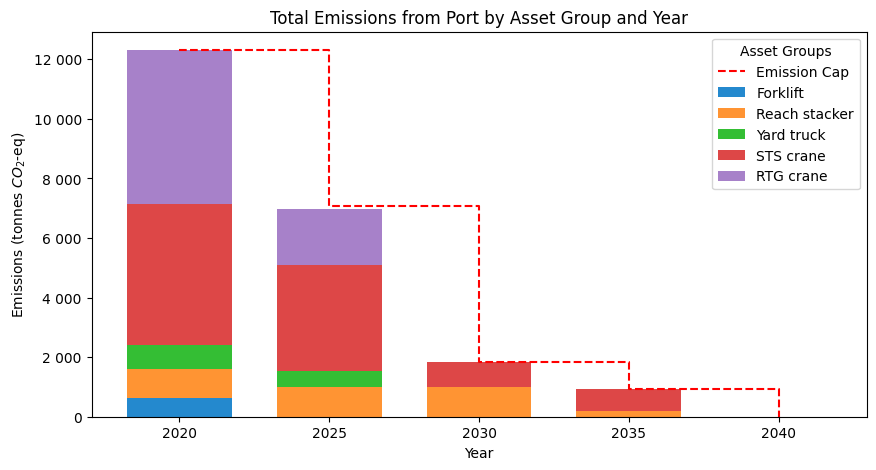

In [121]:
# Calculating total emissions for each asset group in each year
grouped_emissions_data = pd.DataFrame(index=asset_groups.keys(), columns=T)

for group, assets in asset_groups.items():
    for t in T:
        total_emissions = 0
        for a in assets:
            total_emissions += emissions_data.loc[a, t]
        grouped_emissions_data.loc[group, t] = total_emissions


# Plotting the grouped emissions data
fig, ax = plt.subplots(figsize=(10, 5))

# Bottom for stacking bars
bottom = np.zeros(len(T))

# Plotting stacked bar chart for emissions by asset group
for group in grouped_emissions_data.index:
    ax.bar(T, grouped_emissions_data.loc[group], label=group, color=assets_colors[group], bottom=bottom, width=3.5)
    bottom += grouped_emissions_data.loc[group]

# Plotting the emission cap as a step function
caps = [E_cap[t] for t in T]
ax.step(T, caps, where='post', color='red', linestyle='--', label='Emission Cap')

# labels and title
ax.set_xlabel('Year')
ax.set_ylabel(r'Emissions (tonnes $CO_2$-eq)')
ax.set_title('Total Emissions from Port by Asset Group and Year')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))
plt.xticks(T, T)
ax.legend(title='Asset Groups')

plt.show()


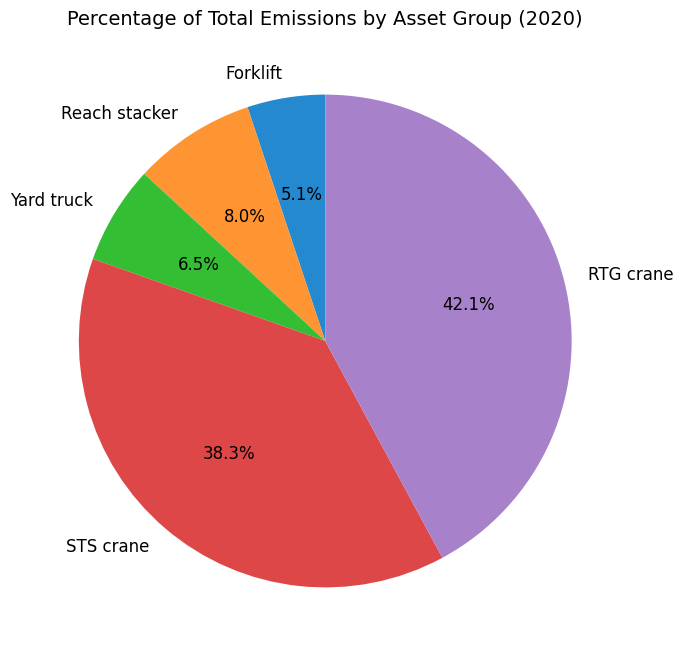

In [122]:
# Calculating total emissions for 2020 (first time period) by asset group
emissions_2020 = {group: 0 for group in asset_groups.keys()}
for group, assets in asset_groups.items():
    for asset in assets:
        emissions_2020[group] += emissions_data.loc[asset, 2020]

# Calculating total emissions for all groups in 2020
total_emissions_2020 = sum(emissions_2020.values())

# Calculating percentage contributions for each group
emissions_percentage_2020 = {group: (emission / total_emissions_2020) * 100 for group, emission in emissions_2020.items()}

# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    emissions_percentage_2020.values(),
    labels=emissions_percentage_2020.keys(),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
    colors = list(assets_colors.values())
)
ax.set_title("Percentage of Total Emissions by Asset Group (2020)", fontsize=14)

plt.show()

#### Fuel mix percentages each year

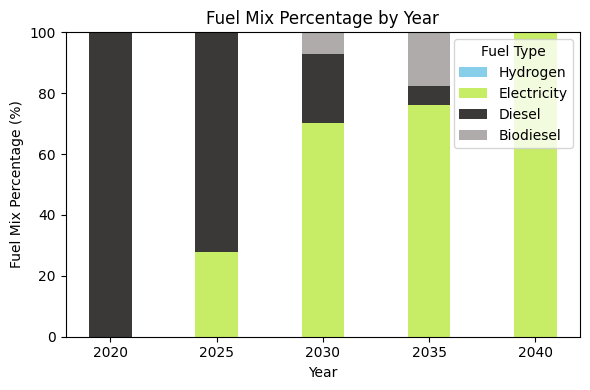

In [123]:
# Initializing a dictionary to store the total kWh usage by year and energy source
fuel_mix_by_year = {year: {fuel: 0 for fuel in E} for year in T}

# Aggregating the kWh consumption for each year and energy source
for a in A:  
    for e in E:  
        for p in P:  
            for t in T:  
                if z[a, e, p, t].x > 0:  
                    # kWh consumed by asset a for energy source e with powertrain p in year t
                    kWh_consumed = Q_a[a] * z[a, e, p, t].x / K_p[p]
                    fuel_mix_by_year[t][e] += kWh_consumed

# Normalizing to obtain percentages for each energy source
for year in T:
    total_kWh = sum(fuel_mix_by_year[year].values())
    for fuel in E:
        if total_kWh > 0:
            fuel_mix_by_year[year][fuel] = (fuel_mix_by_year[year][fuel] / total_kWh) * 100

# Plotting the fuel mix as stacked bar chart
bottoms = np.zeros(len(T))
bar_width = 2

# Colors for each energy source
colors = {
    'Hydrogen': '#87CEEB',
    'Electricity': '#C6ED65',
    'Diesel': '#3B3838',
    'Biodiesel': '#AFABAB'
}

fig, ax = plt.subplots(figsize=(6, 4))
for fuel in colors.keys():
    fuel_data = [fuel_mix_by_year[year][fuel] for year in T]
    ax.bar(T, fuel_data, bottom=bottoms, label=fuel, color=colors.get(fuel, 'gray'), width=bar_width)
    bottoms += np.array(fuel_data) 

ax.set_xlabel('Year')
ax.set_ylabel('Fuel Mix Percentage (%)')
ax.set_title('Fuel Mix Percentage by Year')
ax.set_ylim(0, 100)
ax.set_xticks(T)
ax.legend(title="Fuel Type", loc='upper right')
plt.tight_layout()
plt.show()


#### Asset group decarbonization pathway

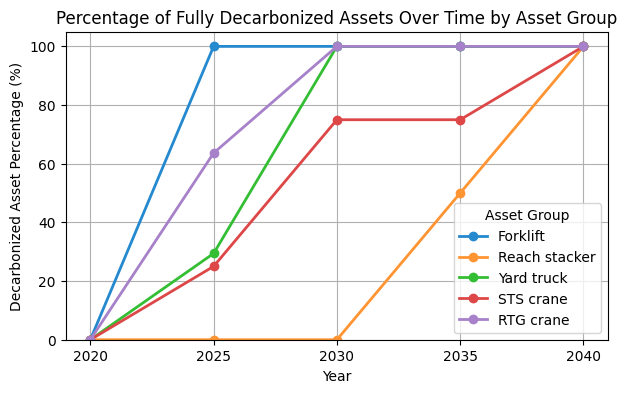

In [124]:
decarbonization_progress_by_group = {group: {t: 0 for t in T} for group in asset_groups}
 
# Calculating the decarbonization percentage for each group and year
for group, assets in asset_groups.items():
    total_assets_in_group = len(assets)
 
    for t in T:
        fully_decarbonized_count = 0
       
        for a in assets:
            is_fully_decarbonized = False
           
            # Checking if the asset is powered by either hydrogen or electricity in year t
            for p in P:  
                if round(z[a, 'Hydrogen', p, t].x) == 1.0 or round(z[a, 'Electricity', p, t].x) == 1.0:
                    is_fully_decarbonized = True
                    break 
 
            if is_fully_decarbonized:
                fully_decarbonized_count += 1
 
        # Calculating the percentage of fully decarbonized assets 
        decarbonization_progress_by_group[group][t] = (fully_decarbonized_count / total_assets_in_group) * 100
 
# Plotting the decarbonization progress as a line chart
plt.figure(figsize=(7, 4))
for group, progress in decarbonization_progress_by_group.items():
    years = list(progress.keys())
    decarbonized_percentage = list(progress.values())
   
    plt.plot(years, decarbonized_percentage, marker='o', linestyle='-', linewidth=2, color=assets_colors[group] , label=group)
 

plt.xlabel('Year')
plt.xticks(T,T)
plt.ylabel('Decarbonized Asset Percentage (%)')
plt.title('Percentage of Fully Decarbonized Assets Over Time by Asset Group')
plt.ylim(0, 105)  
plt.legend(title="Asset Group")
plt.grid(True)
plt.show()

#### Combined fuel mix and decarbonization of assets

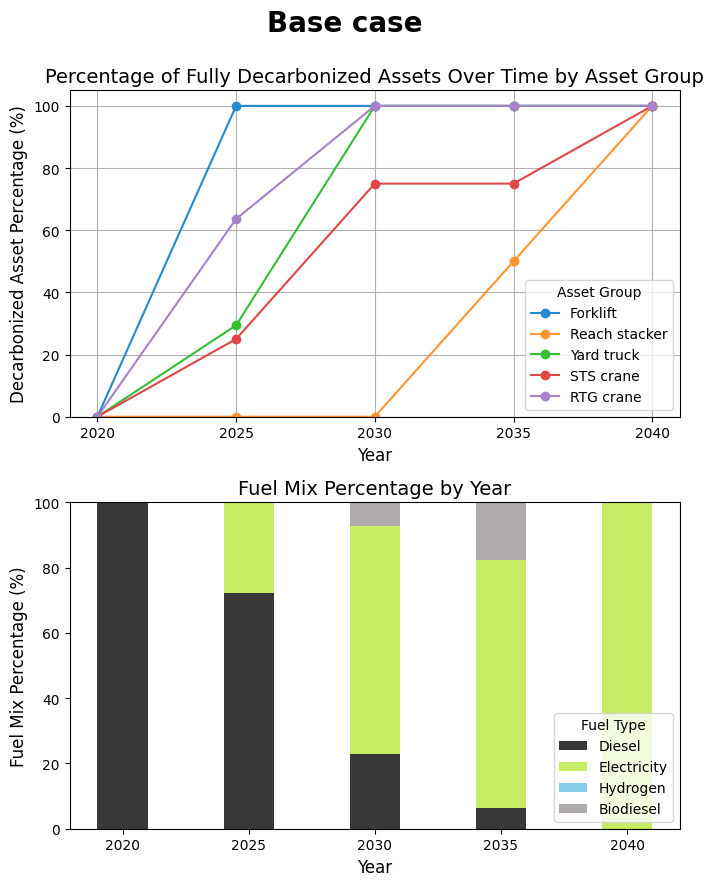

In [125]:
fig, axes = plt.subplots(2, 1, figsize=(7, 9))
fig.suptitle("Base case", fontsize=20, fontweight='bold')

# Plot 1: Decarbonization Progress
for group, progress in decarbonization_progress_by_group.items():
    axes[0].plot(progress.keys(), progress.values(), marker='o', color=assets_colors[group], label=group)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Decarbonized Asset Percentage (%)', fontsize=12)
axes[0].set_title('Percentage of Fully Decarbonized Assets Over Time by Asset Group', fontsize=14)
axes[0].set_xticks(T)
axes[0].set_ylim(0, 105)
axes[0].legend(title="Asset Group", fontsize=10)
axes[0].grid(True, alpha=1)

# Plot 2: Fuel Mix Percentage
bottoms = np.zeros(len(T))
bar_width = 2
for fuel in E:
    fuel_data = [fuel_mix_by_year[year][fuel] for year in T]
    axes[1].bar(T, fuel_data, bottom=bottoms, label=fuel, color=colors.get(fuel, 'gray'), width=bar_width)
    bottoms += np.array(fuel_data)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Fuel Mix Percentage (%)', fontsize=12)
axes[1].set_title('Fuel Mix Percentage by Year', fontsize=14)
axes[1].set_xticks(T)
axes[1].set_ylim(0, 100)
axes[1].legend(title="Fuel Type", loc='lower right', fontsize=10)


plt.tight_layout(rect=[0, 0, 1, 0.98])  
plt.show()


#### Combined plot fuel mix, decarbonization, emissions

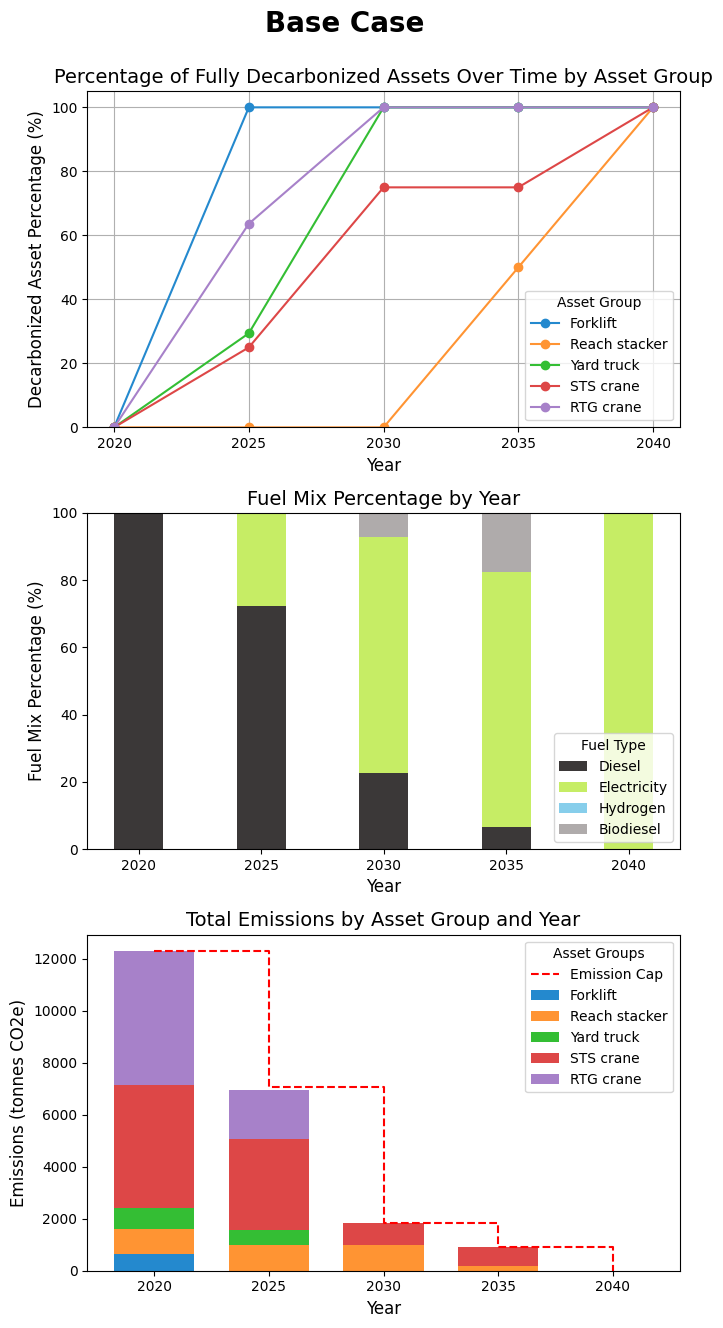

In [126]:
fig, axes = plt.subplots(3, 1, figsize=(7, 13.5))
fig.suptitle("Base Case", fontsize=20, fontweight='bold')

# Plot 1: Decarbonization 
for group, progress in decarbonization_progress_by_group.items():
    axes[0].plot(progress.keys(), progress.values(), marker='o', color=assets_colors[group], label=group)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Decarbonized Asset Percentage (%)', fontsize=12)
axes[0].set_title('Percentage of Fully Decarbonized Assets Over Time by Asset Group', fontsize=14)
axes[0].set_xticks(T)
axes[0].set_ylim(0, 105)
axes[0].legend(title="Asset Group", fontsize=10)
axes[0].grid(True, alpha=1)

# Plot 2: Fuel mix
bottoms = np.zeros(len(T))
bar_width = 2
for fuel in E:
    fuel_data = [fuel_mix_by_year[year][fuel] for year in T]
    axes[1].bar(T, fuel_data, bottom=bottoms, label=fuel, color=colors.get(fuel, 'gray'), width=bar_width)
    bottoms += np.array(fuel_data)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Fuel Mix Percentage (%)', fontsize=12)
axes[1].set_title('Fuel Mix Percentage by Year', fontsize=14)
axes[1].set_xticks(T)
axes[1].set_ylim(0, 100)
axes[1].legend(title="Fuel Type", loc='lower right', fontsize=10)

# Plot 3: Emissions by equipment group
bottom = np.zeros(len(T))
for group in grouped_emissions_data.index:
    axes[2].bar(T, grouped_emissions_data.loc[group], label=group, color=assets_colors[group], bottom=bottom, width=3.5)
    bottom += grouped_emissions_data.loc[group]

# Plotting
caps = [E_cap[t] for t in T]
axes[2].step(T, caps, where='post', color='red', linestyle='--', label='Emission Cap')

axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('Emissions (tonnes CO2e)', fontsize=12)
axes[2].set_title('Total Emissions by Asset Group and Year', fontsize=14)
axes[2].set_xticks(T)
axes[2].legend(title='Asset Groups', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])  
plt.show()

### <span style='color:white'>Costs</span>

#### Annualized CAPEX and OPEX for one asset over time

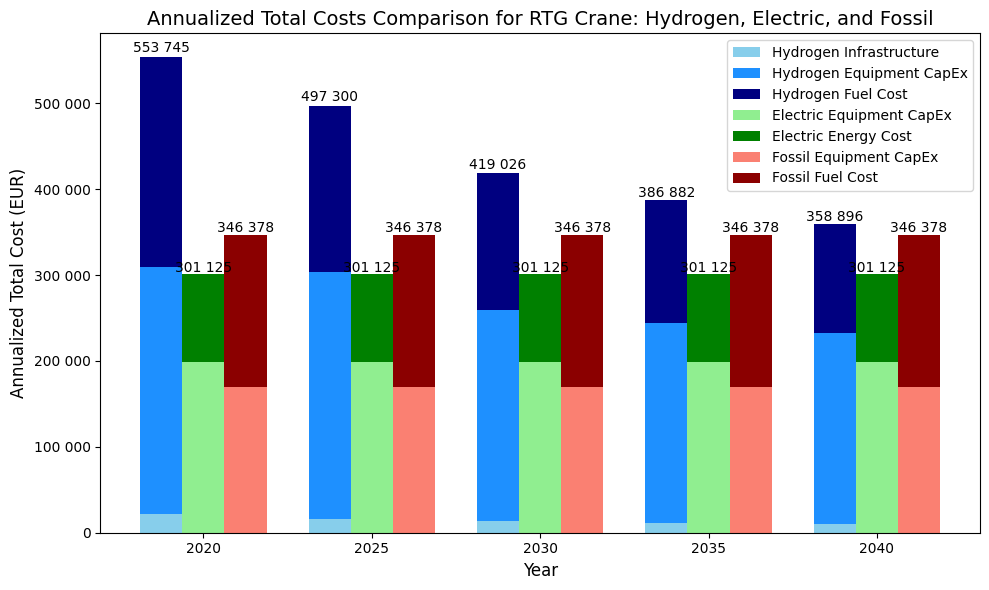

In [127]:
# Extracting hydrogen infrastructure costs from C_II
hydrogen_infra_costs = [cost for (energy_source, year), cost in C_II.items() if energy_source == 'Hydrogen']
# Extracting the CAPEX cost for hydrogen-powered RTG cranes across all years from C_IA
rtg__hyd_capex = [cost for (asset, powertrain, year), cost in C_IA.items() if asset == 'RTGCrane_NaN_1' and powertrain == 'Hydrogen']
rtg_el_capex = [cost for (asset, powertrain, year), cost in C_IA.items() if asset == 'RTGCrane_NaN_1' and powertrain == 'Electric']

# Specify specific asset to study and hydrogen energy source
asset = 'RTGCrane_NaN_1'
energy_source = 'Hydrogen'

# Calculating hydrogen fuel cost for each year
rtg_hyd_opex = []
rtg_el_opex = []

rtg_hyd_opex = [
    Q_a[asset] * C_et[(energy_source, year)] / (LHV_e[energy_source] * K_p['Hydrogen'])
    for year in T
]
energy_source = 'Electricity'
rtg_el_opex = [
    Q_a[asset] * C_et[(energy_source, year)] / (LHV_e[energy_source] * K_p['Electric'])
    for year in T
]

infra_crf = calculate_crf(R, LI)
equipment_crf = calculate_crf(R, L_a['RTGCrane_NaN_1'])

# Annualized costs for hydrogen and electric
annualized_hydrogen_infra_cost = np.array(hydrogen_infra_costs) * infra_crf
annualized_hydrogen_equipment_cost = np.array(rtg__hyd_capex) * equipment_crf
annualized_electric_equipment_cost = np.array(rtg_el_capex) * equipment_crf

# Calculating total costs per year for hydrogen and electric
hydrogen_total_costs = []
electric_total_costs = []

for year, hydrogen_fuel_cost, electric_energy_cost in zip(T, rtg_hyd_opex, rtg_el_opex):
    hydrogen_total_cost = (
        annualized_hydrogen_infra_cost +
        annualized_hydrogen_equipment_cost +
        rtg_hyd_opex
    )
    electric_total_cost = (
        annualized_electric_equipment_cost +
        rtg_el_opex
    )
    hydrogen_total_costs.append(hydrogen_total_cost)
    electric_total_costs.append(electric_total_cost)

# Extracting fossil fuel data
fossil_equipment_costs = [cost for (asset, powertrain, year), cost in C_IA.items() if asset == 'RTGCrane_NaN_1' and powertrain == 'ICE']

# Annualized costs for fossil fuel
annualized_fossil_equipment_cost = np.array(fossil_equipment_costs) * equipment_crf

# Fossil fuel cost for each year
energy_source = 'Diesel'
rtg_fossil_opex = [
    Q_a[asset] * C_et[(energy_source, year)] / (LHV_e[energy_source] * K_p['ICE'])
    for year in T
]

# Total costs per year for hydrogen, electric, and fossil
hydrogen_total_costs = annualized_hydrogen_infra_cost + annualized_hydrogen_equipment_cost + rtg_hyd_opex
electric_total_costs = annualized_electric_equipment_cost + rtg_el_opex
fossil_total_costs =  annualized_fossil_equipment_cost + rtg_fossil_opex

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25 
bar_positions = np.arange(len(T))

# Stacked bars for hydrogen
ax.bar(bar_positions - bar_width, annualized_hydrogen_infra_cost, width=bar_width, label="Hydrogen Infrastructure", color='skyblue')
ax.bar(bar_positions - bar_width, annualized_hydrogen_equipment_cost, bottom=annualized_hydrogen_infra_cost, width=bar_width, label="Hydrogen Equipment CapEx", color='dodgerblue')
ax.bar(bar_positions - bar_width, rtg_hyd_opex, bottom=(annualized_hydrogen_infra_cost + annualized_hydrogen_equipment_cost), width=bar_width, label="Hydrogen Fuel Cost", color='navy')

# Stacked bars for electric
ax.bar(bar_positions, annualized_electric_equipment_cost, width=bar_width, label="Electric Equipment CapEx", color='lightgreen')
ax.bar(bar_positions, rtg_el_opex, bottom=annualized_electric_equipment_cost, width=bar_width, label="Electric Energy Cost", color='green')

# Stacked bars for fossil
ax.bar(bar_positions + bar_width, annualized_fossil_equipment_cost, width=bar_width, label="Fossil Equipment CapEx", color='salmon')
ax.bar(bar_positions + bar_width, rtg_fossil_opex, bottom=(annualized_fossil_equipment_cost), width=bar_width, label="Fossil Fuel Cost", color='darkred')

# Data labels
for i in range(len(T)):
    hydrogen_total = hydrogen_total_costs[i]
    electric_total = electric_total_costs[i]
    fossil_total = fossil_total_costs[i]

    ax.text(i - bar_width, hydrogen_total*1.01, f"{hydrogen_total:,.0f}".replace(",", " "), ha='center', fontsize=10, color='black')
    ax.text(i, electric_total*1.01, f"{electric_total:,.0f}".replace(",", " "), ha='center', fontsize=10, color='black')
    ax.text(i + bar_width, fossil_total*1.01, f"{fossil_total:,.0f}".replace(",", " "), ha='center', fontsize=10, color='black')

# x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(T)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annualized Total Cost (EUR)', fontsize=12)
ax.set_title('Annualized Total Costs Comparison for RTG Crane: Hydrogen, Electric, and Fossil', fontsize=14)


ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", " ")))

plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

#### Annualized CAPEX and OPEX for several assets in a given year

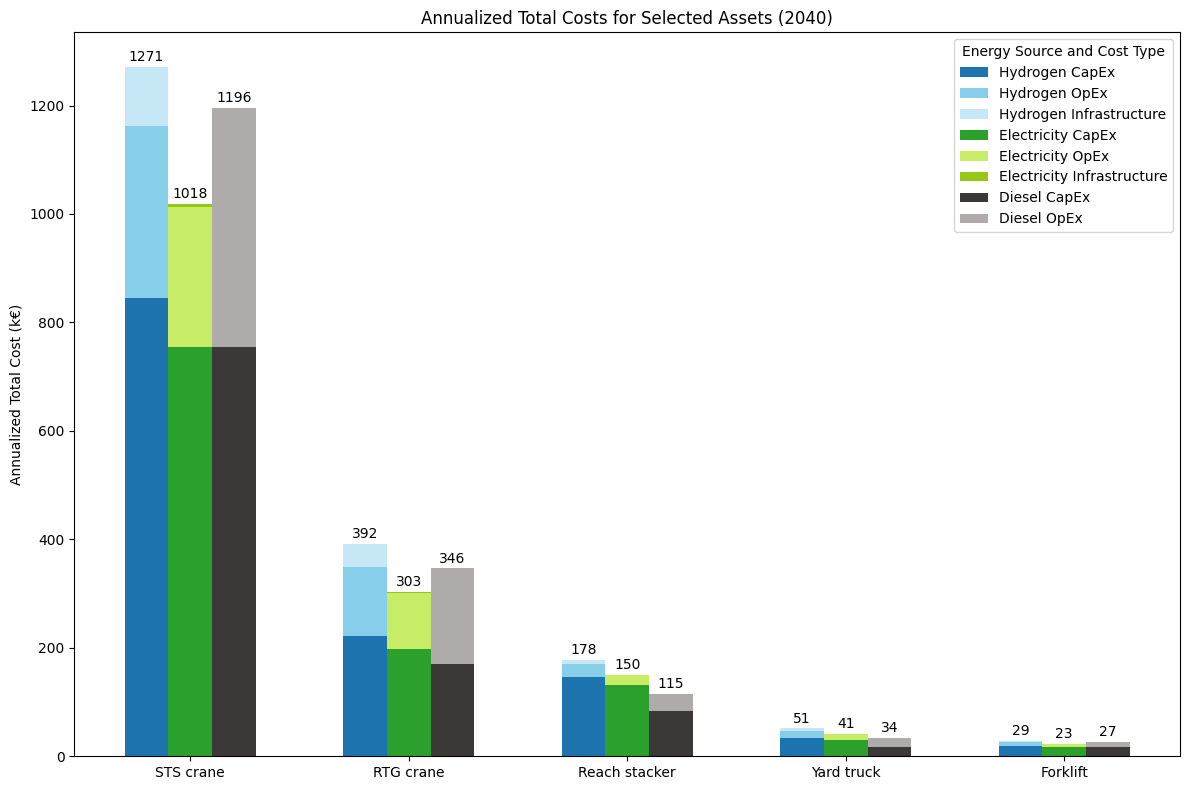

In [128]:
# List of assets and corresponding powertrain types to analyze
assets = ["STSCrane_NaN_1", "RTGCrane_NaN_1", "ReachStacker_45t_1", "YardTruck_NaN_1", "Forklift_10t_1"]
energy_sources = ['Hydrogen', 'Electricity', 'Diesel']
# Given year to study
year = 2040

# colors for each energy source [Infrastructure, Capex, Opex]
colors = {
    'Hydrogen': ['#C6E8F6', '#1E74AE', '#87CEEB'],      
    'Electricity': ['#95C717', '#2CA02C', '#C6ED65'],    
    'Diesel': ['#f5c6cb', '#3B3838', '#AFABAB']    
}

# mapping from energy to powertrain
energy_to_powertrain = {
    'Hydrogen': 'Hydrogen',
    'Electricity': 'Electric',
    'Diesel': 'ICE'
}

# Initializing dictionaries to hold costs
annualized_costs = {asset: {energy: {'infra': 0, 'capex': 0, 'opex': 0} for energy in energy_sources} for asset in assets}

# CRFs for infrastructure 
infra_crf = calculate_crf(R, LI)

# Looping through each asset and energy source to compute annualized costs
for asset in assets:
    if asset == 'STSCrane_NaN_9999' and year == 2025: # Change to exlcude some asset in given year from list above
        continue
    else:
        equipment_crf = calculate_crf(R, L_a[asset])  # CRF for each asset

        for energy in energy_sources:
            powertrain = energy_to_powertrain[energy] 

            # Infrastructure cost for hydrogen (only for assets using hydrogen)
            if (energy == 'Hydrogen') and (energy, year) in C_II:
                infra_cost = C_II[(energy, year)]* infra_crf
                annualized_costs[asset][energy]['infra'] =  Q_a[asset]/(K_I[energy] * K_p['Hydrogen']) * infra_cost  / 1000  # Convert to thousands of euros

            # Infrastructure cost for hydrogen
            if (energy == "Electricity") and (energy, year) in C_II:
                infra_cost = C_II[(energy, year)]* infra_crf
                annualized_costs[asset][energy]['infra'] = Q_a[asset] /( K_I[energy] * K_p['Electric']) * infra_cost /1000   # Convert to thousands of euros

            # Capex for each asset and powertrain
            capex_cost = C_IA.get((asset, powertrain, year), 0)
            annualized_costs[asset][energy]['capex'] = capex_cost * equipment_crf / 1000  # Convert to thousands of euros

            # Opex for each asset, energy source, and powertrain efficiency
            if energy == 'Diesel':
                opex_cost = Q_a[asset] * C_et[(energy, year)] / (LHV_e[energy] * K_p['ICE'])
            elif energy == 'Electricity':
                opex_cost = Q_a[asset] * C_et[(energy, year)] / (LHV_e[energy] * K_p['Electric'])
            else:  # Hydrogen
                opex_cost = Q_a[asset] * C_et[(energy, year)] / (LHV_e[energy] * K_p['Hydrogen'])
            
            annualized_costs[asset][energy]['opex'] = opex_cost / 1000  # Convert to thousands of euros

# Mapping of asset names to simplified forms
asset_name_mapping = {
    "STSCrane_NaN_1": "STS crane",
    "RTGCrane_NaN_1": "RTG crane",
    "ReachStacker_45t_1": "Reach stacker",
    "YardTruck_NaN_1": "Yard truck",
    "Forklift_10t_1": "Forklift"
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
positions = np.arange(len(assets))

for idx, energy in enumerate(energy_sources):
    infra_costs = [annualized_costs[asset][energy]['infra'] for asset in assets]
    capex_costs = [annualized_costs[asset][energy]['capex'] for asset in assets]
    opex_costs = [annualized_costs[asset][energy]['opex'] for asset in assets]

    capex_bars = ax.bar(
        positions + idx * bar_width - bar_width, capex_costs, width=bar_width,
        label=f"{energy} CapEx", color=colors[energy][1]
    )
    opex_bars = ax.bar(
        positions + idx * bar_width - bar_width, opex_costs, bottom=capex_costs,
        width=bar_width, label=f"{energy} OpEx", color=colors[energy][2]
    )

    if (energy == 'Hydrogen') or (energy == 'Electricity'):
        infra_bars = ax.bar(
            positions + idx * bar_width - bar_width, infra_costs, 
            bottom=[capex + opex for capex, opex in zip(capex_costs, opex_costs)],
            width=bar_width, label=f"{energy} Infrastructure", color=colors[energy][0]
        )

    # Data labels
    for i, asset in enumerate(assets):
        total_cost = infra_costs[i] + capex_costs[i] + opex_costs[i]
        ax.text(
            positions[i] + idx * bar_width - bar_width, total_cost + 5,
            f"{total_cost:.0f}", ha='center', va='bottom', fontsize=10
        )

simplified_asset_names = [asset_name_mapping[asset] for asset in assets]
ax.set_xticks(positions)
ax.set_xticklabels(simplified_asset_names, rotation=0, ha="center")

ax.set_ylabel('Annualized Total Cost (k€)')
ax.set_title('Annualized Total Costs for Selected Assets (2040)')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))

plt.legend(title='Energy Source and Cost Type')
plt.tight_layout()
plt.show()


#### Normalized annual costs

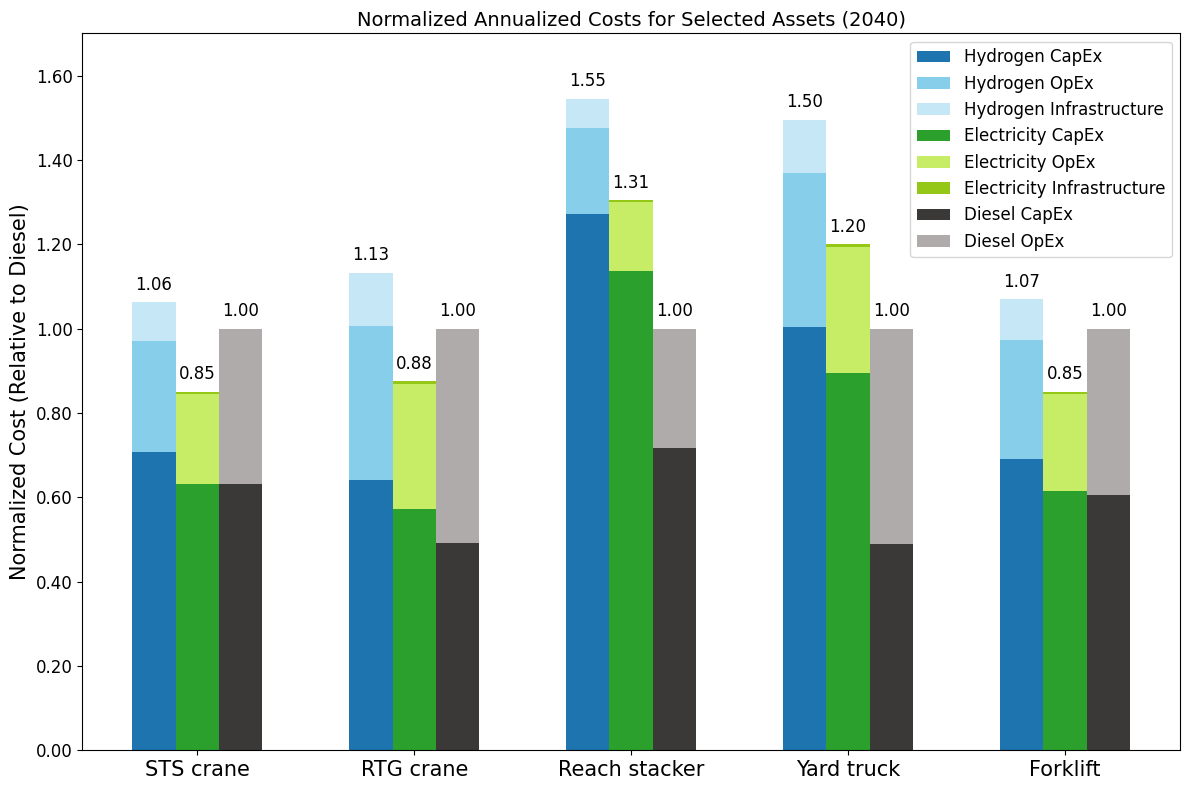

In [129]:
# Initializing dictionaries to hold normalized costs
normalized_costs = {asset: {energy: {'infra': 0, 'capex': 0, 'opex': 0} for energy in energy_sources} for asset in assets}

max_total_cost = 0

# Normalize each cost component by the diesel version of the asset
for asset in assets:
    diesel_total = sum(annualized_costs[asset]['Diesel'].values())  # Total cost of diesel version

    for energy in energy_sources:
        if diesel_total > 0:  # Avoiding division by zero
            for cost_type in ['infra', 'capex', 'opex']:
                normalized_costs[asset][energy][cost_type] = (
                    annualized_costs[asset][energy][cost_type] / diesel_total
                )

# Plotting normalized costs
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
positions = np.arange(len(assets))

# Plotting normalized stacked bars for each cost component
for idx, energy in enumerate(energy_sources):
    infra_costs = [normalized_costs[asset][energy]['infra'] for asset in assets]
    capex_costs = [normalized_costs[asset][energy]['capex'] for asset in assets]
    opex_costs = [normalized_costs[asset][energy]['opex'] for asset in assets]

    capex_bars = ax.bar(
        positions + idx * bar_width - bar_width, capex_costs, width=bar_width,
        label=f"{energy} CapEx", color=colors[energy][1]
    )
    opex_bars = ax.bar(
        positions + idx * bar_width - bar_width, opex_costs, bottom=capex_costs,
        width=bar_width, label=f"{energy} OpEx", color=colors[energy][2]
    )

    if (energy == 'Hydrogen') or (energy == 'Electricity'):
        infra_bars = ax.bar(
            positions + idx * bar_width - bar_width, infra_costs, 
            bottom=[capex + opex for capex, opex in zip(capex_costs, opex_costs)],
            width=bar_width, label=f"{energy} Infrastructure", color=colors[energy][0]
        )

    # Data labels
    for i, asset in enumerate(assets):
        total_cost = infra_costs[i] + capex_costs[i] + opex_costs[i]
        max_total_cost = max(max_total_cost, total_cost)
        ax.text(
            positions[i] + idx * bar_width - bar_width, total_cost + 0.02,
            f"{total_cost:.2f}", ha='center', va='bottom', fontsize=12
        )

simplified_asset_names = [asset_name_mapping[asset] for asset in assets]
ax.set_xticks(positions)
ax.set_xticklabels(simplified_asset_names, rotation=0, ha="center", fontsize=14)

ax.set_ylim(0, max_total_cost * 1.1)
ax.set_ylabel('Normalized Cost (Relative to Diesel)', fontsize=15)
ax.set_title(f'Normalized Annualized Costs for Selected Assets ({year})', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)  
ax.tick_params(axis='x', which='major', labelsize=15)  

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


#### Total present value (PV) for each cost component

In [130]:
# Initializing total PV variables
total_pv_capex = 0
total_pv_opex = 0
total_pv_infra = 0

# Looping through years 
for t in T:
    # Discount factor for the year
    df = discount_factor(t)
    
    # Calculatin PV of CapEx 
    for a in A:
        for p in P:
            if y[a,p,t].x > 0.5:  # Checking if investment is made
                total_pv_capex += df * C_IA[a, p, t]

    
    # Calculating PV of OpEx
    for a in A:
        for e in E:
            for p in P:
                for t_prime in range(0,delta_t):
                    total_pv_opex += discount_factor(t+t_prime) * C_et[e, t] * Q_a[a] * (1 / (LHV_e[e]*K_p[p])) * z[a, e, p, t].x 
    
    # Calculate PV of infrastructure 
    for e in EA:
        for t_prime in range(t,T_last+1):
            total_pv_infra += (delta[e,t].x * CRF * C_II[e,t] * discount_factor(t_prime)) + (gamma[e,t].x * CRF * C_EXT[e,t] * discount_factor(t_prime))


# Storing in fictionary
total_pv_costs = {
    "CapEx": total_pv_capex,
    "OpEx": total_pv_opex,
    "Infrastructure": total_pv_infra,
    "Total": total_pv_capex + total_pv_opex + total_pv_infra
}

### <span style='color:white'>Infrastructure capacity</span>

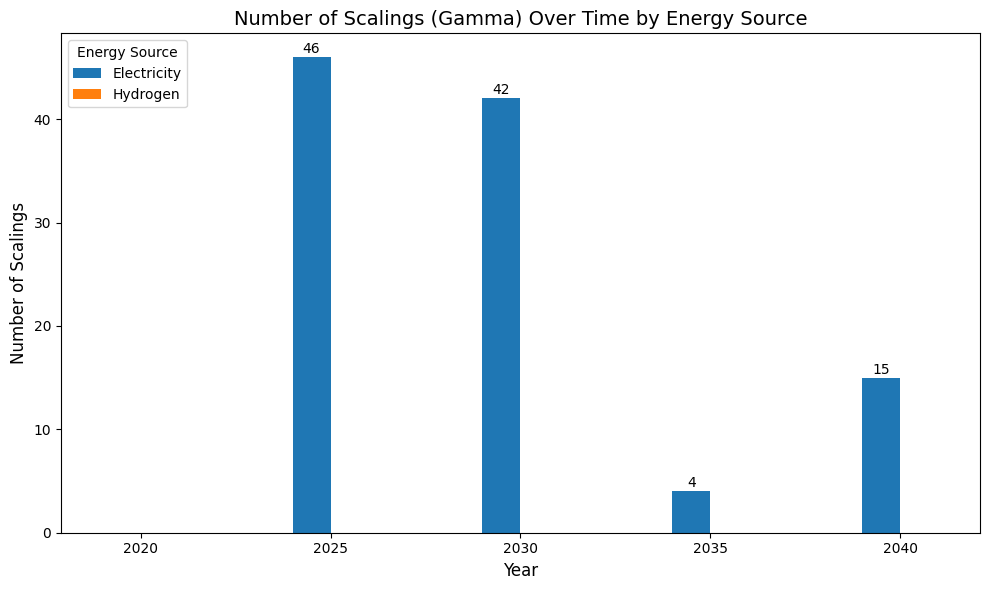

In [131]:
filtered_EA = [e for e in EA] # change if some energy source needs to be filtered out

gamma_results = {e: [gamma[e, t].x if gamma[e, t].x > 0 else 0 for t in T] for e in filtered_EA}

# Plotting number of scalings over time
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2 
positions = np.arange(len(T))  # x-axis positions for bars

# Bar chart used for plot
for idx, (e, values) in enumerate(gamma_results.items()):
    bars = ax.bar(positions + idx * bar_width, values, width=bar_width, label=e)

    # Data labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only labels for bars with non-zero value
            ax.text(
                bar.get_x() + bar.get_width() / 2, height + 0.1,
                f"{height:.0f}", ha='center', va='bottom', fontsize=10
            )

# Cusotmized plot
ax.set_xticks(positions + (len(filtered_EA) - 1) * bar_width / 2)
ax.set_xticklabels(T)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Scalings', fontsize=12)
ax.set_title('Number of Scalings (Gamma) Over Time by Energy Source', fontsize=14)
ax.legend(title='Energy Source', fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()


### <span style='color:white'>Energy demand</span>

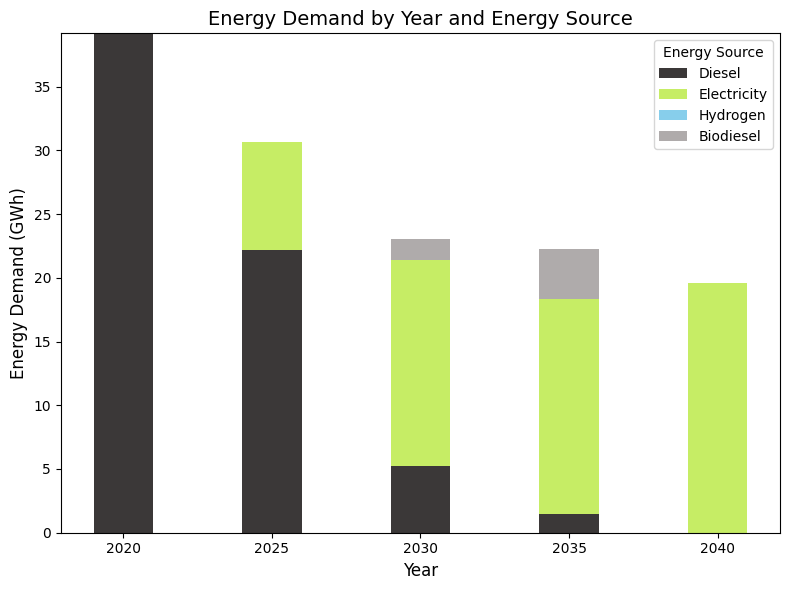

In [132]:
# Calculating energy demand for each year
energy_demand_by_year = {year: {energy: 0 for energy in E} for year in T}

# Looping through assets, energy sources, powertrains and years
for a in A:
    for e in E:
        for p in P:
            for t in T:
                energy_demand_by_year[t][e] += Q_a[a] * z[a, e, p, t].x / (K_p[p]) /10**6  # Converting to GWh


# Converting to pandas dataframe
energy_demand_df = pd.DataFrame(energy_demand_by_year)

energy_sources = list(E)  # List of energy sources
years = T  # List of years


# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))


bottom = np.zeros(len(years))

# Colors for each energy source
colors = {
    'Hydrogen': '#87CEEB',
    'Electricity': '#C6ED65',
    'Diesel': '#3B3838',
    'Biodiesel': '#AFABAB'
}

# Plotting a stacked bar chart for emissions by asset group
for source in energy_demand_df.index:
    ax.bar(T, energy_demand_df.loc[source], label=source, bottom=bottom, color=colors.get(source, 'gray'), width=2)
    bottom += energy_demand_df.loc[source]

# Customizing plot
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy Demand (GWh)', fontsize=12)
ax.set_title('Energy Demand by Year and Energy Source', fontsize=14)
plt.xticks(years, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Energy Source", fontsize=10)

plt.tight_layout()
plt.show()

### <span style='color:white'>Scenario comparisons</span>

NB! All these scenarios under must be run to get the plot

In [133]:
if excel_path == 'base_case.xlsx':
    pv_base = total_pv_costs
elif excel_path == 'base_case_wo_caps.xlsx':
    pv_base_wo_caps = total_pv_costs
elif excel_path == 'scenario_1.xlsx':
    pv_no_el = total_pv_costs
elif excel_path == 'scenario_2.xlsx':
    pv_no_infra = total_pv_costs
elif excel_path == 'scenario_3.xlsx':
    pv_subs = total_pv_costs
elif excel_path == 'scenario_4.xlsx':
    pv_no_cap = total_pv_costs

#### PV of costs per scenario

In [134]:
try:
    # Scenarios PV data (choose name as wanted)
    scenarios = ['Base Case', 'S0', 'S1', 'S2', 'S3', 'S4']

    # Extracting cost components for each scenario
    cost_components = ['CapEx', 'OpEx', 'Infrastructure']
    base_case_costs = [pv_base[component] / 1e6 for component in cost_components]
    base_no_caps = [pv_base_wo_caps[component] / 1e6 for component in cost_components]
    no_el_costs = [pv_no_el[component] / 1e6 for component in cost_components]
    no_infra_costs = [pv_no_infra[component] / 1e6 for component in cost_components]
    subs_costs = [pv_subs[component] / 1e6 for component in cost_components]
    no_2024_cap = [pv_no_cap[component] / 1e6 for component in cost_components]

    # Stacked bar chart data
    scenarios_costs = [base_case_costs, base_no_caps, no_el_costs, no_infra_costs, subs_costs, no_2024_cap]
    totals = np.array([pv_base['Total'], pv_base_wo_caps['Total'], pv_no_el['Total'], pv_no_infra['Total'], pv_subs['Total'], pv_no_cap['Total']]) / 1e6

    bar_width = 0.5
    positions = np.arange(len(scenarios))

    # Colors for cost components (Capex, Opex, infrastructure)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # stacked bars
    fig, ax = plt.subplots(figsize=(10, 6))

    bottoms = np.zeros(len(scenarios))

    # Looping through cost components and plotting
    for idx, component in enumerate(cost_components):
        costs = [scenario[idx] for scenario in scenarios_costs]
        ax.bar(positions, costs, bar_width, label=component, color=colors[idx], bottom=bottoms, zorder=3)
        bottoms += np.array(costs)

    # data labels
    for i, total in enumerate(totals):
        ax.text(positions[i], bottoms[i] + 0.05, f"{total:.1f}", ha='center', va='bottom', fontsize=13)

    # Horizontal dashed line for the base case total
    base_case_total = totals[0]  # First scenario is the base case
    ax.axhline(y=base_case_total, color='black', linestyle='--', linewidth=1)

    # Customizing plot
    ax.set_xticks(positions)
    ax.set_xticklabels(scenarios, fontsize=13)
    ax.set_ylabel('Present Value (M€)', fontsize=13)
    #ax.set_title('Present Value of Total Costs by Scenario')
    ax.legend(fontsize=11)
    ax.grid(axis='y', color='gray', alpha=0.7, zorder=1)

    # y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()
except:
    print('NB! All scenarios must be run first before the plot can be shown')

NB! All scenarios must be run first before the plot can be shown


### Sensitivity of discount factor

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 247557 rows, 89630 columns and 1149510 nonzeros
Model fingerprint: 0x80105150
Variable types: 6410 continuous, 83220 integer (83210 binary)
Coefficient statistics:


  Matrix range     [1e+00, 1e+10]
  Objective range  [1e+02, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolved: 2213 rows, 2504 columns, 11207 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 9
  Lift-and-project: 2
  Cover: 5
  Implied bound: 33
  Clique: 25
  MIR: 20
  Zero half: 11
  RLT: 5
  Relax-and-lift: 17

Explored 2783 nodes (9822 simplex iterations) in 0.32 seconds (0.14 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 8.86877e+07 8.86877e+07 8.86877e+07 ... 1.96592e+08

Optimal solution found (tolerance 1.00e-04)
Best objective 8.868770524670e+07, best bound 8.867893065409e+07, gap 0.0099%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, usin

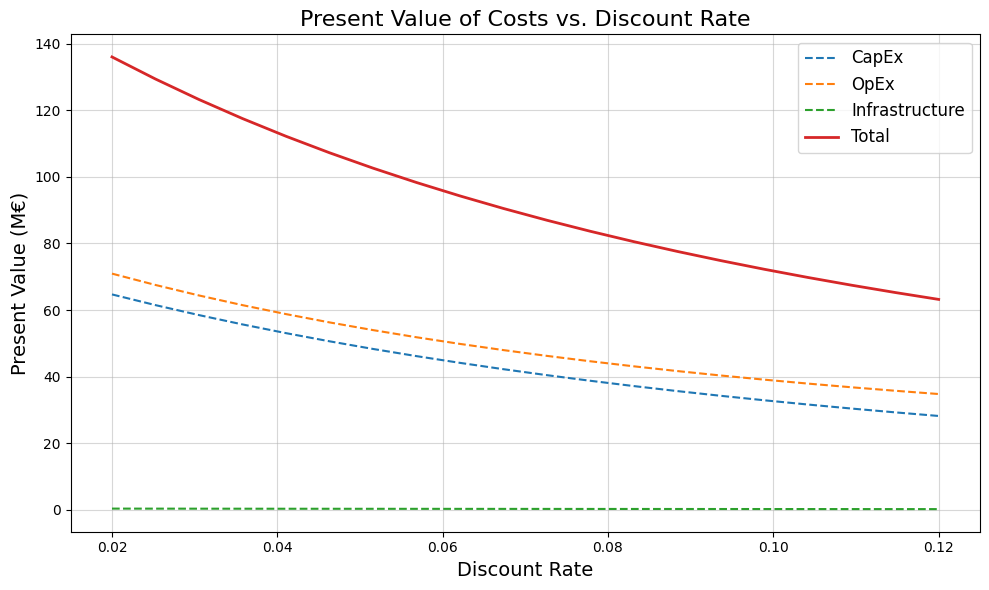

In [135]:
# Range of discount rates
discount_rates = np.linspace(0.02, 0.12, 20)

# Dictionary to store PV costs for each discount rate
pv_costs_by_rate = {rate: {"CapEx": 0, "OpEx": 0, "Infrastructure": 0, "Total": 0} for rate in discount_rates}

# Model run for each rate value
for rate in discount_rates:
    # Discount rate
    R = rate
    # Discount factor and CRF
    discount_factor = lambda t: (1 / (1 + R)) ** (t - t_0)
    CRF = calculate_crf(R, LI)
    
    # Model run
    model.optimize()
    
    # Checking if model has optimal solution
    if model.status == GRB.OPTIMAL:
        total_pv_capex = 0
        total_pv_opex = 0
        total_pv_infra = 0

        for t in T:
            df = discount_factor(t)
            # Capex
            total_pv_capex += sum(df * C_IA[a, p, t] * y[a, p, t].x for a in A for p in P if y[a, p, t].x > 0.5)

            # Opex
            for a in A:
                for e in E:
                    for p in P:
                        for t_prime in range(0, delta_t):
                            total_pv_opex += discount_factor(t + t_prime) * C_et[e, t] * Q_a[a] * (1 / (LHV_e[e] * K_p[p])) * z[a, e, p, t].x
            
            # Infrastructure
            for e in EA:
                for t_prime in range(t, T_last + 1):
                    total_pv_infra += (
                        delta[e, t].x * CRF * C_II[e, t] * discount_factor(t_prime)
                        + gamma[e, t].x * CRF * C_EXT[e, t] * discount_factor(t_prime)
                    )

        # Storing results
        pv_costs_by_rate[rate]["CapEx"] = total_pv_capex
        pv_costs_by_rate[rate]["OpEx"] = total_pv_opex
        pv_costs_by_rate[rate]["Infrastructure"] = total_pv_infra
        pv_costs_by_rate[rate]["Total"] = total_pv_capex + total_pv_opex + total_pv_infra

# Preparing data for plot, converting to millions
rates = list(pv_costs_by_rate.keys())
capex_values = [pv_costs_by_rate[rate]["CapEx"] / 1e6 for rate in rates]
opex_values = [pv_costs_by_rate[rate]["OpEx"] / 1e6 for rate in rates]
infra_values = [pv_costs_by_rate[rate]["Infrastructure"] / 1e6 for rate in rates]
total_values = [pv_costs_by_rate[rate]["Total"] / 1e6 for rate in rates]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rates, capex_values, label="CapEx", linestyle="--")
plt.plot(rates, opex_values, label="OpEx", linestyle="--")
plt.plot(rates, infra_values, label="Infrastructure", linestyle="--")
plt.plot(rates, total_values, label="Total", linestyle="-", linewidth=2)

plt.xlabel("Discount Rate", fontsize=14)
plt.ylabel("Present Value (M€)", fontsize=14)
plt.title("Present Value of Costs vs. Discount Rate", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


### <span style='color:white'>Other plots used in the thesis</span>

#### Emission caps over time

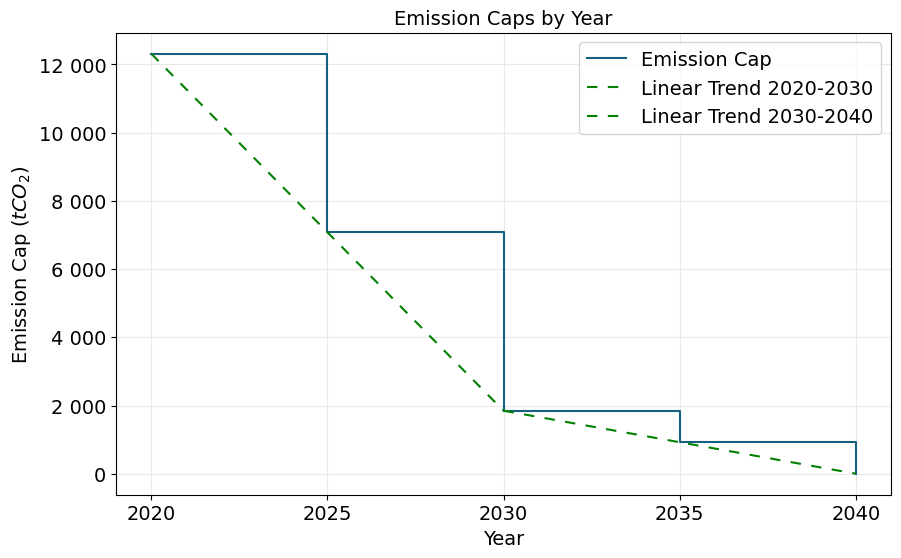

In [136]:
# Corrected path to the Downloads folder
#save_path = os.path.join(os.path.expanduser("~"), "Downloads", "emission_caps_oslo.png")

years = T
caps = [E_cap[t] for t in T] 

# Plotting the step function
plt.figure(figsize=(10, 6))
plt.step(years, caps, where='post', label="Emission Cap", color='#156082')

# Adding linear striped line between 2020 to 2032
x1 = [2020, 2030]
y1 = [caps[0], caps[2]]
plt.plot(x1, y1, linestyle=(0, (5, 5)), color='green', label="Linear Trend 2020-2030")

# Adding linear striped line between 2032 to 2040
x2 = [2030, 2040]
y2 = [caps[2], 0]
plt.plot(x2, y2, linestyle=(0, (5, 5)), color='green', label="Linear Trend 2030-2040")

# Setting integer ticks for the years on the x-axis
plt.xticks(years, fontsize=14) 
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))

# Customizing plot
plt.xlabel("Year", fontsize=14)
plt.ylabel(r"Emission Cap $(tCO_2)$", fontsize=14)
plt.legend(fontsize=14)
plt.grid(color='#E8E8E8')
plt.title("Emission Caps by Year", fontsize=14)

# plt.savefig(save_path)  # saving the plot
plt.show()

#### Regression for (diesel) forklift prices

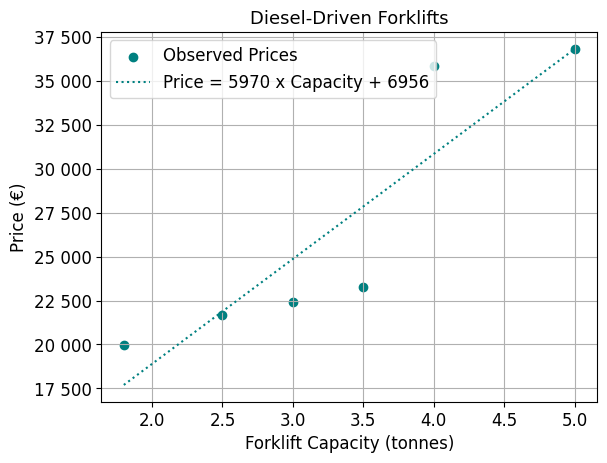

In [137]:
# Data (hard-coded)
capacities = np.array([1.8, 2.5, 3, 3.5, 4, 5])
prices = np.array([19997, 21671, 22394, 23254, 35844, 36773])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(capacities, prices)

# Creating the regression line for plotting
regression_line = slope * capacities + intercept

# Plotting data points
plt.scatter(capacities, prices, color='teal', label="Observed Prices")
plt.plot(capacities, regression_line, linestyle='dotted', color='teal', label=f"Price = {slope:.0f} x Capacity + {intercept:.0f}")

# Cusotmizing plot
plt.xlabel("Forklift Capacity (tonnes)", fontsize=12)
plt.ylabel("Price (€)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Diesel-Driven Forklifts", fontsize=13)

plt.legend(fontsize=12, loc='upper left')
plt.grid(True)

plt.show()

#### Regression for (electric) forklift prices

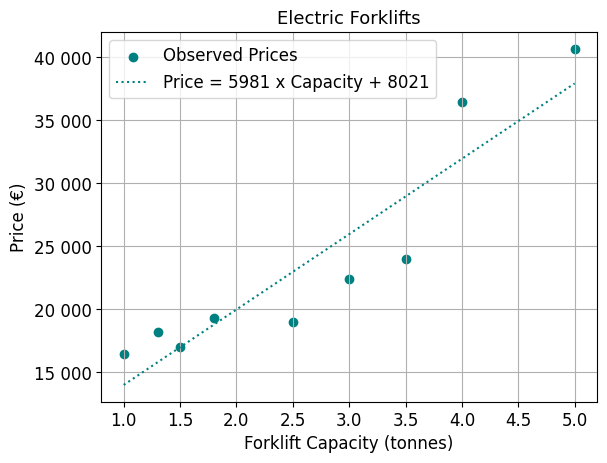

In [138]:
# Data (hard-coded)
capacities = np.array([1, 1.3, 1.5, 1.8, 2.5, 3, 3.5, 4, 5])
prices = np.array([16425, 18188, 17001, 19280, 18962, 22385, 23976, 36463, 40667])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(capacities, prices)

# Creating the regression line for plotting
regression_line = slope * capacities + intercept

# Plotting data points
plt.scatter(capacities, prices, color='teal', label="Observed Prices")
plt.plot(capacities, regression_line, linestyle='dotted', color='teal', label=f"Price = {slope:.0f} x Capacity + {intercept:.0f}")

# Cusotmizing plot
plt.xlabel("Forklift Capacity (tonnes)", fontsize=12)
plt.ylabel("Price (€)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Electric Forklifts", fontsize=13)

plt.legend(fontsize=12)
plt.grid(True)

plt.show()

#### Hydrogen premium based on TCO calculations on ICCT working paper

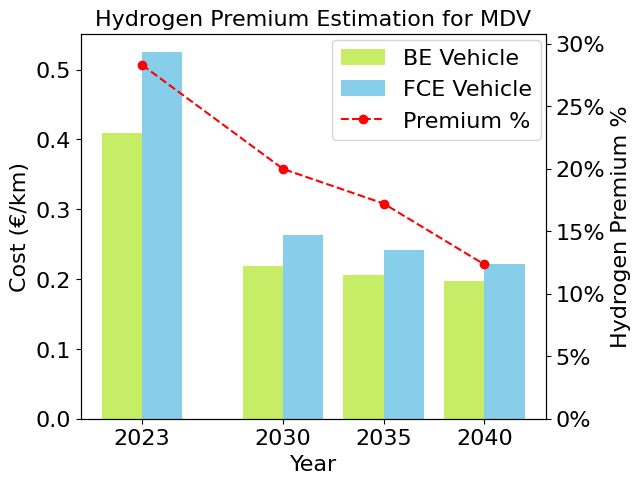

In [139]:
# Data
years = [2023, 2030, 2035, 2040]
bev = [0.4094, 0.2188, 0.2058, 0.1978]
fcv = [0.5252, 0.2625, 0.2412, 0.2222]

# Calcultion on the premium
premium = []
for i in range(0, len(years)):
    premium.append(fcv[i] / bev[i] - 1)

# Plotting bar charts for BEV and FCV costs and line chart for premium %
fig, ax1 = plt.subplots(figsize=(6, 5))

width = 2  
ax1.bar([year - 0.5 * width for year in years], bev, width=width, label='BE Vehicle', color='#C6ED65')
ax1.bar([year + 0.5 * width for year in years], fcv, width=width, label='FCE Vehicle', color='#87CEEB')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Cost (€/km)', fontsize=16)
#ax1.legend(fontsize=14)

ax1.set_xticks(years)
ax1.tick_params(axis='both', labelsize=16)

# Secondary y-axis for premium % plotted as a line
ax2 = ax1.twinx()
ax2.plot(years, premium, label='Premium %', marker='o', linestyle='--', color='red')
ax2.set_ylabel('Hydrogen Premium %', fontsize=16)
#ax2.legend(fontsize=14)

# Secondary y-axis as percentages and start from 0
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
ax2.set_ylim(0, max(premium)+0.025)
ax2.tick_params(axis='y', labelsize=16)

fig.legend(loc="upper left", bbox_to_anchor=(0.525, 0.89), fontsize=16)

plt.title('Hydrogen Premium Estimation for MDV', fontsize=16)
#plt.grid()

plt.show()

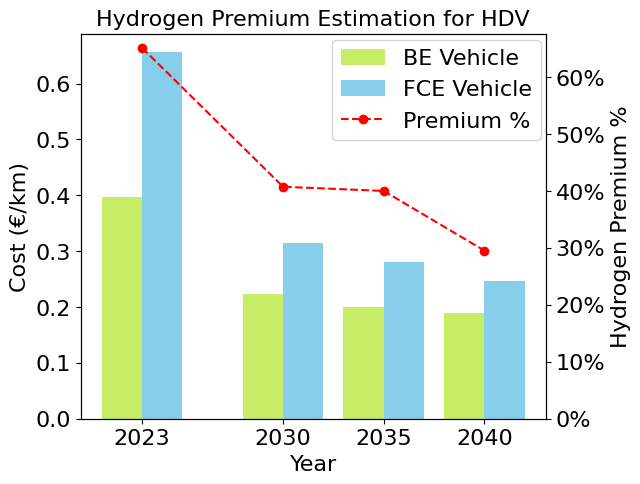

In [140]:
# Data
years = [2023, 2030, 2035, 2040]
bev = [0.3975, 0.2234, 0.2000, 0.1897]
fcv = [0.6563, 0.3144, 0.2800, 0.2457]

# Calcultion on the premium
premium = []
for i in range(0, len(years)):
    premium.append(fcv[i] / bev[i] - 1)

# Plotting bar charts for BEV and FCV costs and line chart for premium %
fig, ax1 = plt.subplots(figsize=(6, 5))

width = 2  
ax1.bar([year - 0.5 * width for year in years], bev, width=width, label='BE Vehicle', color='#C6ED65')
ax1.bar([year + 0.5 * width for year in years], fcv, width=width, label='FCE Vehicle', color='#87CEEB')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Cost (€/km)', fontsize=16)
#ax1.legend(loc="upper left", fontsize=12)

ax1.set_xticks(years)
ax1.tick_params(axis='both', labelsize=16)

# Secondary y-axis for premium % plotted as a line
ax2 = ax1.twinx()
ax2.plot(years, premium, label='Premium %', marker='o', linestyle='--', color='red')
ax2.set_ylabel('Hydrogen Premium %', fontsize=16)
#ax2.legend(loc="upper right", fontsize=12)
# Secondary Y-axis as percentages and start from 0
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
ax2.set_ylim(0, max(premium)+0.025)
ax2.tick_params(axis='y', labelsize=16)

plt.title('Hydrogen Premium Estimation for HDV', fontsize=16)
#plt.grid()

fig.legend(loc="upper left", bbox_to_anchor=(0.525, 0.89), fontsize=16)

plt.show()

#### Energy prices over time

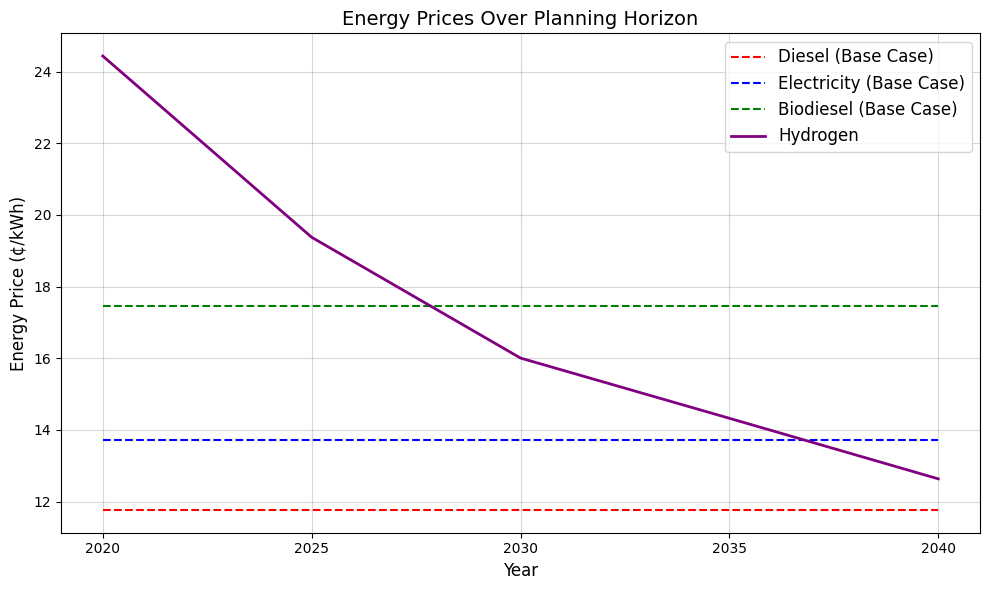

In [141]:
# Extracting energy prices over the planning horizon for each energy source
diesel_prices = [C_et['Diesel', t] / LHV_e['Diesel'] *100 for t in T]
electricity_prices = [C_et['Electricity', t] / LHV_e['Electricity'] *100 for t in T]
biodiesel_prices = [C_et['Biodiesel', t] / LHV_e['Biodiesel'] *100 for t in T]
hydrogen_prices = [C_et['Hydrogen', t] / LHV_e['Hydrogen']*100 for t in T]

plt.figure(figsize=(10, 6))

# Prices with dashed lines
plt.plot(T, diesel_prices, linestyle='--', label='Diesel (Base Case)', color='red')
plt.plot(T, electricity_prices, linestyle='--', label='Electricity (Base Case)', color='blue')
plt.plot(T, biodiesel_prices, linestyle='--', label='Biodiesel (Base Case)', color='green')

# Plotting hydrogen with solid line
plt.plot(T, hydrogen_prices, linestyle='-', label='Hydrogen', color='purple', linewidth=2)

# Customizing plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Price (¢/kWh)', fontsize=12)
plt.title('Energy Prices Over Planning Horizon', fontsize=14)
plt.xticks(T, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

#### Combined emission figure

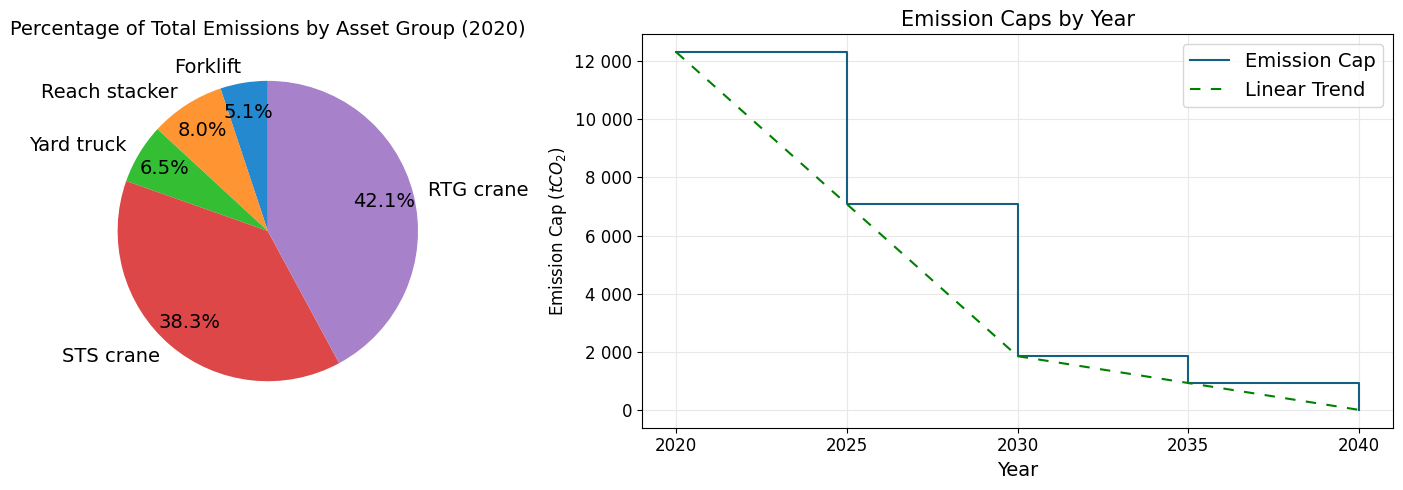

In [142]:
# Combining two of the plots from above into one figure
emissions_2020 = {group: 0 for group in asset_groups.keys()}
for group, assets in asset_groups.items():
    for asset in assets:
        emissions_2020[group] += emissions_data.loc[asset, 2020]

#Total emissions for all asset groups in 2020
total_emissions_2020 = sum(emissions_2020.values())

# Percentage contributions for each group
emissions_percentage_2020 = {
    group: (emission / total_emissions_2020) * 100 for group, emission in emissions_2020.items()
}

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # Allocate 1.5x space to the right subplot

# Left subplot (Pie chart)
ax1 = plt.subplot(gs[0])

# Right subplot (Step chart)
ax2 = plt.subplot(gs[1])

# Plotting the pie chart
ax1.pie(
    emissions_percentage_2020.values(),
    labels=emissions_percentage_2020.keys(),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14},
    pctdistance=0.8,
    colors=list(assets_colors.values())
)
ax1.set_title("Percentage of Total Emissions by Asset Group (2020)", fontsize=14)

# Plotting the step chart for emission caps
years = T
caps = [E_cap[t] for t in T]
ax2.step(years, caps, where='post', label="Emission Cap", color='#156082')

# Adding linear striped lines
ax2.plot([2020, 2030], [caps[0], caps[2]], linestyle=(0, (5, 5)), color='green', label="Linear Trend")
ax2.plot([2030, 2040], [caps[2], 0], linestyle=(0, (5, 5)), color='green')

ax2.set_xticks(years)
ax2.set_xlabel("Year", fontsize=14)
ax2.set_ylabel(r"Emission Cap $(tCO_2)$", fontsize=12)
ax2.legend(fontsize=14)
ax2.grid(color='#E8E8E8')
ax2.set_title("Emission Caps by Year", fontsize=15)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", " ")))
ax2.tick_params(axis='both', which='major', labelsize=12)  
plt.tight_layout()
plt.show()